# Árboles de decisión

Para el estudio de los árboles de decisión, usaremos la base de datos `HELOC` que contiene información sobre la edad, los ingresos y como variable objetivo, si los clientes respondieron o o no a la oferta del banco.

## Árboles de clasificación

In [ ]:

#cargamos las librerías básicas y la base de datos. Es importante tener en cuenta que
#el archivo de la base de datos contiene varias hojas de cálculo y en ese caso se debe
#poner explícitamente el nombre de la hoja de cálculo que se desea trabajar

import pandas as pd

data = pd.read_excel("/content/HELOC.xlsx", sheet_name = "HELOC_Data")
data.head()

,Age,Sex,Income,HELOC
0,30,Female,101000,0
1,25,Male,86000,0
2,20,Male,50000,0
3,26,Male,58000,0
4,18,Female,93000,0


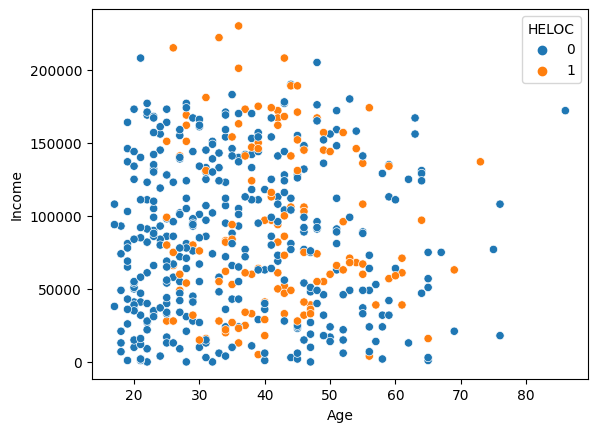

In [ ]:
#si queremos hacer un gráfico de dispersión para visualizar nuestros datos (solo con las
# variables numéricas)

import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data = data, x = 'Age', y = 'Income', hue = 'HELOC')
plt.show()


In [ ]:
#vamos a observar los tipos de variables que tenemos en nuestros datos para saber cuál es la
#mejor forma de tratarlos

data.dtypes

Age        int64
Sex       object
Income     int64
HELOC      int64
dtype: object

In [ ]:
#en este caso, todas las variables son numéricas menos la variable Sex.
#Una solución sencilla para esta limitación es convertir los datos categóricos en enteros
#utilizando codificación dummy o one-hot encoding. En este ejemplo usaremos la codificación
#dummy de pandas. Primero debemos conocer cuántos posibles valores tiene la variable a tratar

data.Sex.unique()



array(['Female', 'Male'], dtype=object)

In [ ]:
#Como solo tiene dos valores, podemos usar solo una columna de unos y ceros en forma de
#variable Booleana. Usaremos la función concat para agregar esa columna dummy a nuestros datos.
#La función drop la usamos para no tener dos columnas, únicamente una.

data = pd.concat([data, pd.get_dummies(data.Sex, drop_first = True)],axis = 1)
data.head()

,Age,Sex,Income,HELOC,Male
0,30,Female,101000,0,0
1,25,Male,86000,0,1
2,20,Male,50000,0,1
3,26,Male,58000,0,1
4,18,Female,93000,0,0


In [ ]:
#Ahora eliminaremos la variable Sex para no tener información redundante

data = data.drop('Sex', axis = 1)
data.head()

,Age,Income,HELOC,Male
0,30,101000,0,0
1,25,86000,0,1
2,20,50000,0,1
3,26,58000,0,1
4,18,93000,0,0


In [ ]:
#comprobaremos nuevamente los tipos de datos en nuestra tabla
data.dtypes

Age       int64
Income    int64
HELOC     int64
Male      uint8
dtype: object

In [ ]:
#Para dividir los datos en un 70% de entrenamiento y un 30% de prueba, utilizamos la función scikit-learn
# train_test_split.

#cargamos la librería que necesitamos
from sklearn.model_selection import train_test_split


#realizamos la partición. Es importante que dentro de los datos no quede la variable objetivo, pero que sí
#quede cargada en las etiquetas.
X_train, X_test, y_train, y_test = train_test_split(data.drop('HELOC', axis = 1), data.HELOC,
                                                    test_size = 0.30, random_state = 321, stratify = data.HELOC)

In [ ]:
#Ahora revisaremos los tamaños de ambos conjuntos
len(X_train)

350

In [ ]:

len(X_test)

150

In [ ]:
#Ya estamos listos para los modelos. Primero debemos cargar las librerías y luego hacemos el instanciamiento
#del modelo

from sklearn.tree import DecisionTreeClassifier

modelo = DecisionTreeClassifier(random_state = 321)

#ahora podemos entrenar el árbol con nuestro conjunto de entrenamiento

basicFit = modelo.fit(X_train, y_train)


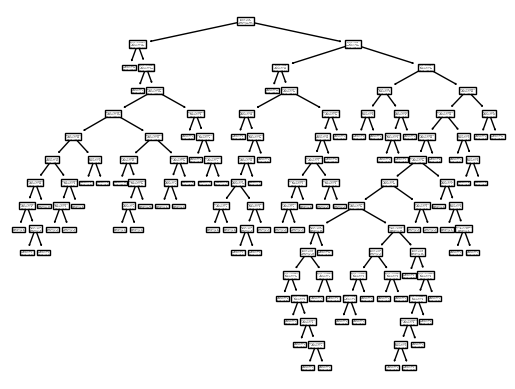

In [ ]:
#también podemos visualizar nuestro modelo

from sklearn import tree

tree.plot_tree(basicFit);

In [ ]:
#dada la complejidad del árbol, intentaremos encontrar el árbol óptimo antes de entrar a interpretar el
#resultado. En este caso haremos una validación cruzada para encontrar los mejores parámetros del modelo

#aquí establecemos los parámetros que queremos ajustar a través de búsqueda heurística
paramGrid = {'ccp_alpha': modelo.cost_complexity_pruning_path(X_train, y_train).ccp_alphas,
             'max_depth': range(1, 6 + 1),
             'min_samples_leaf': range(4, 10 + 1)}

#llamamos la librería que tendrá la función de búsqueda
from sklearn.model_selection import GridSearchCV

#instanciamos la búsqueda
search = GridSearchCV(modelo, paramGrid, cv = 10, scoring = 'roc_auc', n_jobs = -1)

#establecemos la optimización de los parámetros en el espacio de búsqueda con el conjunto
#de entrenamiento
searchFit = search.fit(X_train, y_train)



In [ ]:
#podemos visualizar los resultados de la búsqueda de esta manera
pd.DataFrame(searchFit.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004747,0.001224,0.006536,0.004658,0.0,1,4,"{'ccp_alpha': 0.0, 'max_depth': 1, 'min_sample...",0.809829,0.696581,...,0.794872,0.886752,0.67735,0.790598,0.846154,0.790598,0.76,0.788179,0.060615,1156
1,0.003765,0.000190,0.004164,0.000697,0.0,1,5,"{'ccp_alpha': 0.0, 'max_depth': 1, 'min_sample...",0.809829,0.696581,...,0.794872,0.886752,0.67735,0.790598,0.846154,0.790598,0.76,0.788179,0.060615,1156
2,0.004135,0.001171,0.004839,0.002038,0.0,1,6,"{'ccp_alpha': 0.0, 'max_depth': 1, 'min_sample...",0.809829,0.696581,...,0.794872,0.886752,0.67735,0.790598,0.846154,0.790598,0.76,0.788179,0.060615,1156
3,0.003849,0.000191,0.004079,0.000105,0.0,1,7,"{'ccp_alpha': 0.0, 'max_depth': 1, 'min_sample...",0.809829,0.696581,...,0.794872,0.886752,0.67735,0.790598,0.846154,0.790598,0.76,0.788179,0.060615,1156
4,0.004181,0.001419,0.004778,0.002125,0.0,1,8,"{'ccp_alpha': 0.0, 'max_depth': 1, 'min_sample...",0.809829,0.696581,...,0.794872,0.886752,0.67735,0.790598,0.846154,0.790598,0.76,0.788179,0.060615,1156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,0.004369,0.000172,0.004489,0.000671,0.100575,6,6,"{'ccp_alpha': 0.10057524516300043, 'max_depth'...",0.500000,0.696581,...,0.500000,0.500000,0.67735,0.790598,0.500000,0.790598,0.76,0.621513,0.126071,1387
1424,0.004562,0.000812,0.004585,0.001229,0.100575,6,7,"{'ccp_alpha': 0.10057524516300043, 'max_depth'...",0.500000,0.696581,...,0.500000,0.500000,0.67735,0.790598,0.500000,0.790598,0.76,0.621513,0.126071,1387
1425,0.005112,0.001254,0.005085,0.000896,0.100575,6,8,"{'ccp_alpha': 0.10057524516300043, 'max_depth'...",0.500000,0.696581,...,0.500000,0.500000,0.67735,0.790598,0.500000,0.790598,0.76,0.621513,0.126071,1387
1426,0.004429,0.001615,0.004639,0.003123,0.100575,6,9,"{'ccp_alpha': 0.10057524516300043, 'max_depth'...",0.500000,0.696581,...,0.500000,0.500000,0.67735,0.790598,0.500000,0.790598,0.76,0.621513,0.126071,1387


In [ ]:
#y elegir los parámetros con mejores resultados
pd.DataFrame(searchFit.cv_results_).sort_values('rank_test_score')[['param_ccp_alpha', 'param_max_depth', 'param_min_samples_leaf', 'mean_test_score', 'rank_test_score']].head()


,param_ccp_alpha,param_max_depth,param_min_samples_leaf,mean_test_score,rank_test_score
27,0.0,4,10,0.848162,1
22,0.0,4,5,0.846253,2
26,0.0,4,9,0.845812,3
16,0.0,3,6,0.845752,4
23,0.0,4,6,0.845398,5


In [ ]:

#podemos encontrar el mejor estimador
searchFit.best_estimator_

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=321)

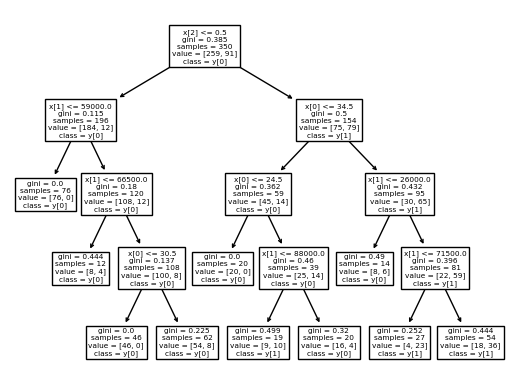

In [ ]:
#para visualizar el árbol, podemos recurrir a dos formas

#forma 1

tree.plot_tree(searchFit.best_estimator_, class_names = True);

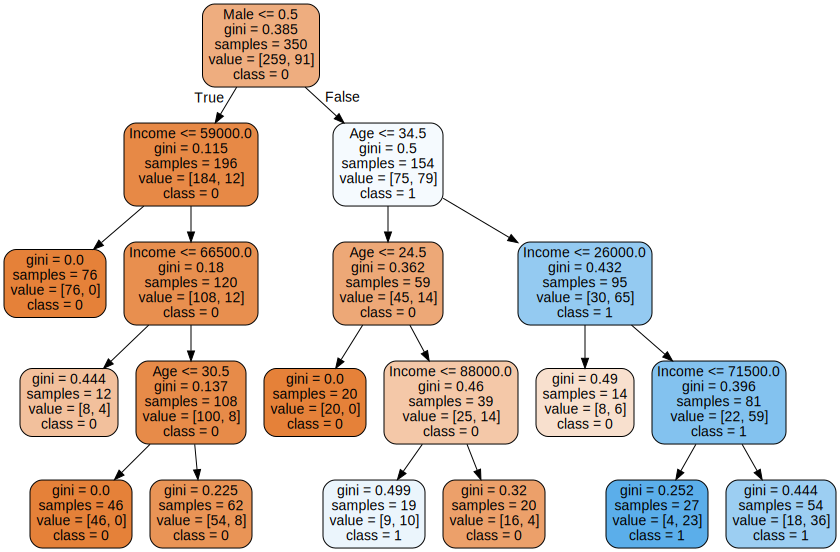

In [ ]:
#forma 2

from graphviz import Source

treeData = tree.export_graphviz(searchFit.best_estimator_,
                                feature_names = X_train.columns,
                                class_names = searchFit.classes_.astype('str'),
                                filled = True,
                                rounded = True)

Source(treeData)

In [ ]:
#ahora podemos predecir la salida para el grupo de test

testPredictions = searchFit.predict(X_test)

In [ ]:

#calculamos la matriz de confusión
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, testPredictions)

array([[91, 20],
       [14, 25]])

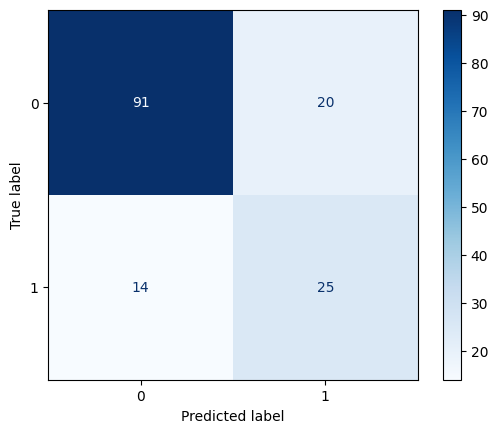

In [ ]:
#si queremos visualizar, tendríamos lo siguiente
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(searchFit,
                                      X_test,
                                      y_test,
                                      cmap = plt.cm.Blues);

In [ ]:

#para hacer la predicción sobre los 20 casos nuevos
new_data = pd.read_excel("/content/HELOC.xlsx", sheet_name = "HELOC_Score")

new_data.head()

,Age,Sex,Income
0,25,Female,45000
1,23,Male,22000
2,50,Female,17000
3,28,Female,38000
4,56,Male,24000


In [ ]:
#hacemos el mismo tratamiento para la columna Sex

new_data = pd.concat([new_data, pd.get_dummies(new_data.Sex, drop_first = True)], axis = 1)
new_data = new_data.drop('Sex', axis = 1)

new_data.head()

In [ ]:
#si difieren los nombres de las columnas por cuestiones de espacio, podemos aplicar la siguiente
#función

new_data = new_data.rename(columns={' Male': 'Male'})

In [ ]:
#realizamos la predicción

new_data_Preds = searchFit.predict(new_data)
new_data_Probs = searchFit.predict_proba(new_data)

In [ ]:
new_data['Predicción: HELOC'] = new_data_Preds
new_data['PostProb: 0'] = new_data_Probs[:, 0]
new_data['PostProb: 1'] = new_data_Probs[:, 1]

new_data.head()

,Age,Income,Male,Predicción: HELOC,PostProb: 0,PostProb: 1
0,25,45000,0,0,1.000000,0.000000
1,23,22000,1,0,1.000000,0.000000
2,50,17000,0,0,1.000000,0.000000
3,28,38000,0,0,1.000000,0.000000
4,56,24000,1,0,0.571429,0.428571


## Árboles de regresión

En el caso de la regresión, usaremos la base de datos `Balance` que contiene los mismos datos de `HELOC` pero agrega el balance de las cuentas de cada cliente.

In [77]:
#importamos la librería
import pandas as pd

#cargamos la base de datos
balance = pd.read_excel('/content/Balance.xlsx')

#visualizamos los primeros registros
balance.head()

,Age,Sex,Income,Balance
0,38,Female,60000,3250
1,20,Male,41000,3546
2,20,Female,134000,1094
3,29,Female,93000,5593
4,27,Female,47000,264


In [78]:
#trabajamos sobre la variable Sex para convertirla en numérica

balance = pd.concat([balance, pd.get_dummies(balance.Sex, drop_first = True)],
                    axis = 1).drop('Sex', axis = 1)

balance.head()

,Age,Income,Balance,Male
0,38,60000,3250,0
1,20,41000,3546,1
2,20,134000,1094,0
3,29,93000,5593,0
4,27,47000,264,0


In [81]:
#hacemos la partición en entrenamiento, validación
from sklearn.model_selection import train_test_split


#vamos a excluir la variable Balance dado que es la variable objetivo
X_train, X_test, y_train, y_test = train_test_split(balance.drop('Balance', axis = 1),
                                                    balance.Balance,
                                                    test_size = 0.30,
                                                    random_state = 321)

In [82]:
#cargamos el regresor
from sklearn.tree import DecisionTreeRegressor

modelo = DecisionTreeRegressor(random_state = 321)

In [88]:
#Fijamos los parámetros que queremos optimizar

paramGrid = {'ccp_alpha': modelo.cost_complexity_pruning_path(X_train, y_train).ccp_alphas,
             'max_depth': range(1, 5),
             'min_samples_leaf': range(1, 5)}

In [89]:
from sklearn.model_selection import GridSearchCV

#armamos la búsqueda
search = GridSearchCV(modelo,
                      paramGrid,
                      cv = 10,
                      scoring = 'neg_root_mean_squared_error',
                      n_jobs = -1)

In [90]:
#entrenamos el modelo
searchFit = search.fit(X_train, y_train)

In [91]:
#organizamos los parámetros de acuerdo a la mejor puntuación
pd.DataFrame(searchFit.cv_results_).sort_values('rank_test_score')[['param_ccp_alpha', 'param_max_depth', 'param_min_samples_leaf', 'mean_test_score', 'rank_test_score']].head()


,param_ccp_alpha,param_max_depth,param_min_samples_leaf,mean_test_score,rank_test_score
3769,119467.206429,3,2,-5860.413928,1
3768,119467.206429,3,1,-5860.413928,1
2680,14343.161911,3,1,-5862.698273,3
2681,14343.161911,3,2,-5862.698273,3
1257,945.575357,3,2,-5862.698273,3


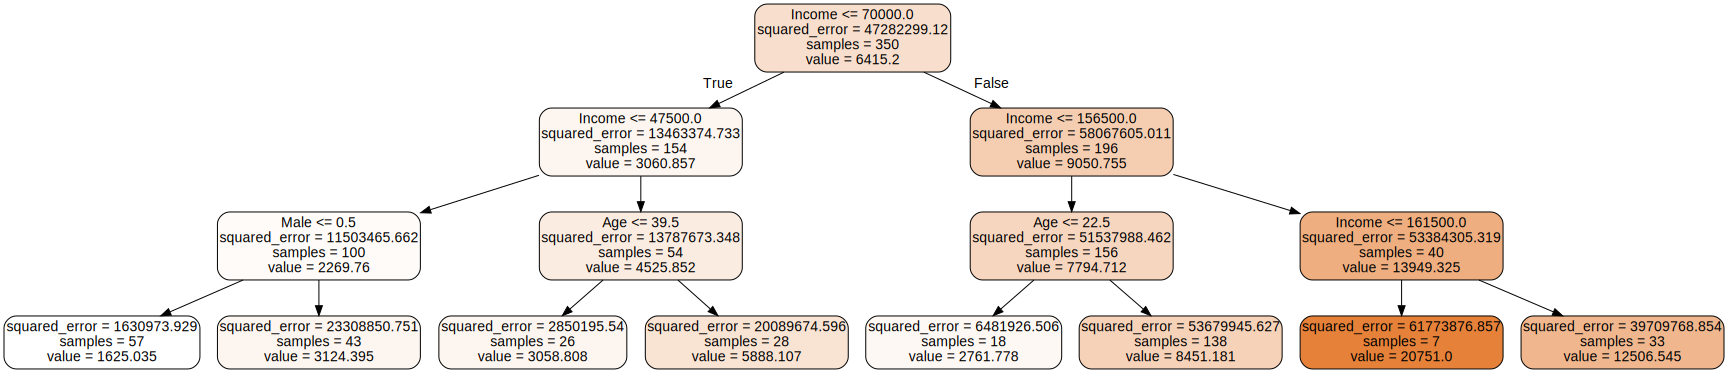

In [92]:
from graphviz import Source
from sklearn import tree

#visualizamos el árbol
treeData = tree.export_graphviz(searchFit.best_estimator_,
                                feature_names = X_train.columns,
                                filled = True,
                                rounded = True)

Source(treeData)

In [93]:
#Hacemos las predicciones para el conjunto de test
testPredictions = searchFit.predict(X_test)


In [95]:
#calculamos una métrica desempeño
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, testPredictions, squared = False)

5609.267881877853

In [96]:
#también podemos visualizar las predicciones
print(testPredictions)

[ 8451.18115942 12506.54545455  8451.18115942  3124.39534884
  8451.18115942  8451.18115942  8451.18115942 12506.54545455
  8451.18115942  1625.03508772 12506.54545455  8451.18115942
  3058.80769231  8451.18115942  8451.18115942  8451.18115942
  8451.18115942  8451.18115942 12506.54545455  8451.18115942
 12506.54545455  8451.18115942  1625.03508772  3124.39534884
  8451.18115942 12506.54545455  8451.18115942  8451.18115942
  8451.18115942  3124.39534884  8451.18115942  1625.03508772
  8451.18115942  8451.18115942  3124.39534884  1625.03508772
 12506.54545455  1625.03508772  3058.80769231  8451.18115942
  8451.18115942  1625.03508772  8451.18115942  8451.18115942
  8451.18115942 20751.          8451.18115942 12506.54545455
  5888.10714286 12506.54545455 12506.54545455  5888.10714286
  8451.18115942 12506.54545455  3124.39534884  3058.80769231
 20751.          1625.03508772 20751.          1625.03508772
  8451.18115942  8451.18115942 12506.54545455  8451.18115942
  2761.77777778  1625.03